In [78]:
import torch
from torch import nn
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader

import torchvision
from torchvision import datasets
from torchvision import transforms
from torchmetrics import Accuracy

import torch.optim as optim
from cleverhans.torch.attacks.projected_gradient_descent import (projected_gradient_descent)

import quantus
import captum
from captum.attr import Saliency, IntegratedGradients, NoiseTunnel

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import random
import copy
import gc
import math

import warnings
warnings.filterwarnings('ignore')

In [80]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [82]:
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
cifar_transforms = transforms.Compose([transforms.RandomHorizontalFlip(),
            transforms.RandomCrop(32, 4),
            transforms.ToTensor(),
            normalize,])

In [84]:
test_dataset =  torchvision.datasets.CIFAR10(root= './datasets', train = False, download=True, transform = cifar_transforms)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=128, pin_memory=True)

Files already downloaded and verified


In [85]:
class_names = test_dataset.classes
class_names

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [88]:
class VGG(nn.Module):
    def __init__(self, features):
        super(VGG,self).__init__()
        self.features = features
        self.classifier = nn.Sequential(
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Dropout(),
            nn.Linear(512,512),
            nn.ReLU(True),
            nn.Linear(512,10)
        )

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, math.sqrt(2. / n))
                m.bias.data.zero_()

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def make_layers(cfg):
    layers = []
    in_channels =3
    for out_channels in cfg:
        if out_channels == 'M':
            layers += [nn.MaxPool2d(kernel_size = 2, stride =2)]
        else:
            conv2d = nn.Conv2d(in_channels, out_channels, kernel_size = 3, padding =1)
            layers += [conv2d, nn.ReLU(inplace = True)]
            in_channels = out_channels
    return nn.Sequential(*layers)

cfg = [64, 64, 'M', 128, 128, 'M', 256, 256, 256, 'M', 512, 512, 512, 'M', 512, 512, 512, 'M']

def vgg16():
    return VGG(make_layers(cfg))

In [90]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_cifar.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model = vgg16().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [92]:
gc.collect()
torch.cuda.empty_cache()
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

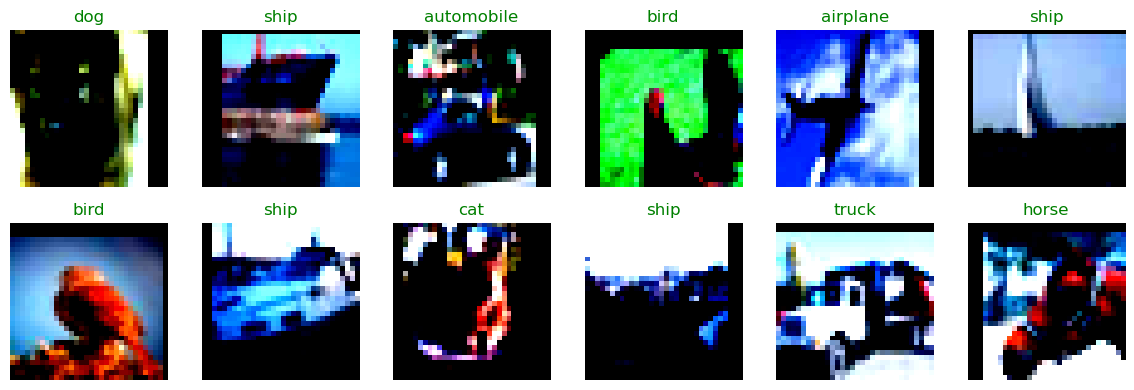

In [168]:
import matplotlib.pyplot as plt
%matplotlib inline
fig = plt.figure(figsize=(12, 4))
indexes = []
rows, cols = 2, 6
for i in range(1, (rows * cols) + 1):
    random_idx = torch.randint(0, len(x_batch), size=[1]).item()
    img, label_gt = x_batch[random_idx], y_batch[random_idx]
    img_temp = img.unsqueeze(dim=0).to(device)
    indexes.append(random_idx)
    # print(img.shape)
    label_pred = torch.argmax(model(img_temp))
    fig.add_subplot(rows, cols, i)
    img = img.permute(1, 2, 0)    # CWH --> WHC
    plt.imshow(img.cpu().numpy(), cmap='gray')
    if label_pred == label_gt:
        plt.title(class_names[label_pred], color='g') # for correct prediction
    else:
        plt.title(class_names[label_pred], color='r') # for incorrect prediction
    plt.axis(False)
    plt.tight_layout();

In [96]:
a_batch_integrad = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad[a_batch_integrad<0] = 0
a_batch_saliency = quantus.normalise_func.normalise_by_negative(Saliency(model).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model)
a_batch_smoothgrad = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())


In [170]:
x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


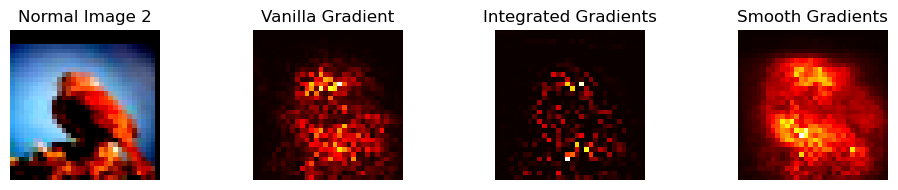

In [172]:
index = indexes[6]
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index], 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad[index], cmap="hot")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
# axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
# axes[4].title.set_text(f"Noise Gradients")
# axes[4].axis("off")
plt.tight_layout()


plt.show()

In [134]:
from pathlib import Path

MODEL_PATH = Path("models")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "vgg_cifar_adv.pth"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME
model_adv = vgg16().to(device)
model_adv.load_state_dict(torch.load(MODEL_SAVE_PATH))

<All keys matched successfully>

In [174]:
x_batch, y_batch = next(iter(test_dataloader))
x_batch, y_batch = x_batch.to(device), y_batch.to(device)

In [108]:
a_batch_integrad_adv = quantus.normalise_func.normalise_by_negative(IntegratedGradients(model_adv).attribute(inputs=x_batch, target=y_batch, baselines=torch.zeros_like(x_batch)).sum(axis=1).cpu().numpy())
a_batch_integrad_adv[a_batch_integrad_adv<0] = 0
a_batch_saliency_adv = quantus.normalise_func.normalise_by_negative(Saliency(model_adv).attribute(inputs=x_batch, target=y_batch, abs=True).sum(axis=1).cpu().numpy())
saliency = Saliency(model_adv)
a_batch_smoothgrad_adv = quantus.normalise_func.normalise_by_negative(NoiseTunnel(saliency).attribute(inputs = x_batch, target = y_batch, nt_type ='smoothgrad', nt_samples = 50, stdevs=0.15).sum(axis=1).cpu().numpy())


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


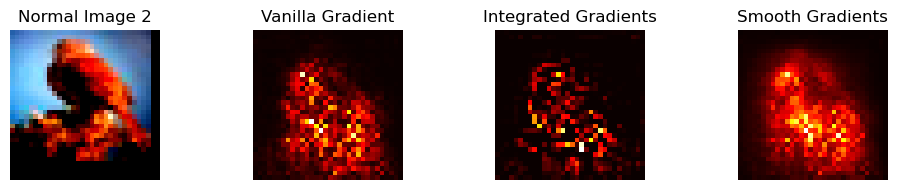

In [178]:
index = indexes[6]
nr_images = 2
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(nr_images*5., int(nr_images)))

#plot normal
axes[0].imshow(np.moveaxis(x_batch[index].cpu().numpy(), 0, -1), vmin=0.0, vmax=1.0)
axes[0].title.set_text(f"Normal Image {y_batch[index].item()}")
axes[0].axis("off")
axes[1].imshow(a_batch_saliency_adv[index], cmap="hot")
axes[1].title.set_text(f"Vanilla Gradient")
axes[1].axis("off")  
axes[2].imshow(a_batch_integrad_adv[index], cmap="hot")
axes[2].title.set_text(f"Integrated Gradients")
axes[2].axis("off")
axes[3].imshow(a_batch_smoothgrad_adv[index], cmap="hot")
axes[3].title.set_text(f"Smooth Gradients")
axes[3].axis("off")
# axes[4].imshow(a_batch_noisegrad[index], cmap="seismic")
# axes[4].title.set_text(f"Noise Gradients")
# axes[4].axis("off")
plt.tight_layout()


plt.show()

In [ ]:
def filter_and_compute_road(model, test_loader, device):

    faithfulness = quantus.ROAD(
    noise=0.01,
    perturb_func=quantus.perturb_func.noisy_linear_imputation,
    percentages=list(range(1, 100, 5)),
    display_progressbar=False)


    score_faithfulness = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = faithfulness(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain,
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        #print(scores)
        
        score_faithfulness.append(scores)
        if len(score_faithfulness) > 1000:
            break
    average_values = {}
    for d in score_faithfulness:
        for key, value in d.items():
            if key in average_values:
                average_values[key] += value
            else:
                average_values[key] = value

    # Divide the sum by the number of dictionaries to get the average
    num_dicts = len(score_faithfulness)
    for key in average_values.keys():
        average_values[key] /= num_dicts

    # Display the average values
    print("Average Values:")
    for key, value in average_values.items():
        print(f"{key}: {value}")


In [ ]:
filter_and_compute_road(model, test_dataloader, device)

In [ ]:
filter_and_compute_road(model_adv, test_dataloader, device)

In [ ]:
import math
def filter_and_compute_input_stability(model, test_loader, device):
    
    metrics = quantus.RelativeInputStability(
        nr_samples =5,
        return_aggregate=False,
         disable_warnings=True,
    )
    score = []
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [ ]:
print("The relative input stability score is: ", filter_and_compute_input_stability(model, test_dataloader, device))

In [ ]:
print("The relative input stability score is: ", filter_and_compute_input_stability(model_adv, test_dataloader, device))

In [ ]:
def filter_and_compute_output_stability(model, test_loader, device):
    metrics = quantus.RelativeOutputStability(
        nr_samples = 5,
         return_aggregate=False,
        disable_warnings=True,
    )
    score = []
    
    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = metrics(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        scores2 = np.nanmean(scores)
        score.append(scores2)
        if len(score) > 1000:
            break 
    score2=score
    return math.log(np.nanmean(score2), 10)

In [ ]:
print("The relative output stability score is: ", filter_and_compute_output_stability(model, test_dataloader, device))

In [ ]:
print("The relative output stability score is: ", filter_and_compute_output_stability(model_adv, test_dataloader, device))

In [ ]:
def filter_and_compute_sparsity(model, test_loader, device):
    
    sparsity = quantus.Sparseness(disable_warnings=True, return_aggregate=True)
    score_sparsity = []

    for i, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        #print(len(x_batch))
        outputs = model(x_batch)
        predictions = torch.argmax(outputs, dim=1)
        correct_mask = predictions == y_batch
        #print(correct_mask)
        x_batch = x_batch[correct_mask]
        y_batch = y_batch[correct_mask]
        #print(len(x_batch))
        x_batch, y_batch = x_batch.cpu().numpy(), y_batch.cpu().numpy()
        scores = sparsity(
                model= model,
                x_batch=x_batch,
                y_batch=y_batch,
                a_batch=None,
                s_batch=None,
                device=device,
                explain_func= quantus.explain, 
                explain_func_kwargs = {"method": "Saliency", "softmax": False})
        score_sparsity.extend(scores)
        if len(score_sparsity) > 1000:
            break 
    return np.nanmean(score_sparsity), np.nanstd(score_sparsity)

In [ ]:
print("The sparsity score is: ", filter_and_compute_sparsity(model, test_dataloader, device))

In [ ]:
print("The sparsity score is: ", filter_and_compute_sparsity(model_adv, test_dataloader, device))